<a href="https://colab.research.google.com/github/AnastasiaKazanas/ANN-Final-Project/blob/main/BOW_FCNN_Covid19FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import kagglehub
import os

In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Kaggle dataset download
path = kagglehub.dataset_download("invalizare/covid-19-fake-news-dataset")
dataset_dir = "/root/.cache/kagglehub/datasets/invalizare/covid-19-fake-news-dataset/"

# Dynamically locate the Val.csv file
file_name = None
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if "Val.csv" in file:
            file_name = os.path.join(root, file)
            break

# Ensure the file is found
if not file_name:
    raise FileNotFoundError("Val.csv not found in the extracted dataset.")

# Load the dataset
df = pd.read_csv(file_name)

# Display dataset preview and statistics
print("Dataset preview:")
print(df.head())

print("\nDataset statistics:")
print(df.describe())

# Check and handle missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)
df.dropna(subset=['tweet', 'label'], inplace=True)

# Rename columns for consistency
df.rename(columns={'tweet': 'text', 'label': 'label'}, inplace=True)

# Display renamed dataset
print("\nRenamed dataset preview:")
print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


100%|██████████| 832k/832k [00:00<00:00, 82.1MB/s]

Extracting files...
Dataset preview:
   id                                              tweet label
0   1  Chinese converting to Islam after realising th...  fake
1   2  11 out of 13 people (from the Diamond Princess...  fake
2   3  COVID-19 Is Caused By A Bacterium, Not Virus A...  fake
3   4  Mike Pence in RNC speech praises Donald Trump’...  fake
4   5  6/10 Sky's @EdConwaySky explains the latest #C...  real

Dataset statistics:
                id
count  2140.000000
mean   1070.500000
std     617.909109
min       1.000000
25%     535.750000
50%    1070.500000
75%    1605.250000
max    2140.000000

Missing values per column:
id       0
tweet    0
label    0
dtype: int64

Renamed dataset preview:
   id                                               text label
0   1  Chinese converting to Islam after realising th...  fake
1   2  11 out of 13 people (from the Diamond Princess...  fake
2   3  COVID-19 Is Caused By A Bacterium, Not Virus A...  fake
3   4  Mike Pence in RNC speech praises D

In [ ]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

# Add filtering for texts with len < 50
new_data = []
new_labels = []
for text, label in zip(df['processed_text'], df['label']):
    if len(text) >= 50:  # Filter out texts shorter than 50 characters
        new_data.append(text)
        new_labels.append(label)

filtered_df = pd.DataFrame({'text': new_data, 'label': new_labels})

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    filtered_df['text'], filtered_df['label'], test_size=0.2, random_state=42
)


In [ ]:
# Investigate unique labels in the dataset
print("Unique labels in the dataset before mapping:")
print(filtered_df['label'].unique())

# Update label mapping based on unique labels
label_mapping = {'fake': 0, 'real': 1}  # Add more mappings if needed

# Map string labels to numeric values
filtered_df['label'] = filtered_df['label'].map(label_mapping)

# Check for unmapped or invalid labels
if filtered_df['label'].isnull().any():
    print("Error: Unmapped or invalid labels detected.")
    print("Label Distribution Before Drop:")
    print(filtered_df['label'].value_counts(dropna=False))

    # Drop rows with invalid labels
    filtered_df = filtered_df.dropna(subset=['label'])

# Ensure labels are integers
filtered_df['label'] = filtered_df['label'].astype(int)

# Debugging information
print("Final Label Distribution:")
print(filtered_df['label'].value_counts())

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    filtered_df['text'], filtered_df['label'], test_size=0.2, random_state=42
)

# Tfidf Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

# Convert labels to tensors
train_labels = torch.tensor(train_labels.values, dtype=torch.long)
test_labels = torch.tensor(test_labels.values, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), train_labels)
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Unique labels in the dataset before mapping:
['fake' 'real']
Final Label Distribution:
label
1    1120
0     974
Name: count, dtype: int64


In [ ]:
# Define the Neural Network
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 2

model = TextClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# Evaluation
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)  # Get the class with the highest score
        y_pred.extend(preds.numpy())
        y_true.extend(y_batch.numpy())

Epoch 1/10, Loss: 33.0231
Epoch 2/10, Loss: 16.5493
Epoch 3/10, Loss: 7.1371
Epoch 4/10, Loss: 3.6977
Epoch 5/10, Loss: 2.0604
Epoch 6/10, Loss: 1.2602
Epoch 7/10, Loss: 0.8370
Epoch 8/10, Loss: 0.5889
Epoch 9/10, Loss: 0.4367
Epoch 10/10, Loss: 0.3321



Model Accuracy: 0.89

Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.84      0.87       187
        True       0.88      0.93      0.90       232

    accuracy                           0.89       419
   macro avg       0.89      0.89      0.89       419
weighted avg       0.89      0.89      0.89       419



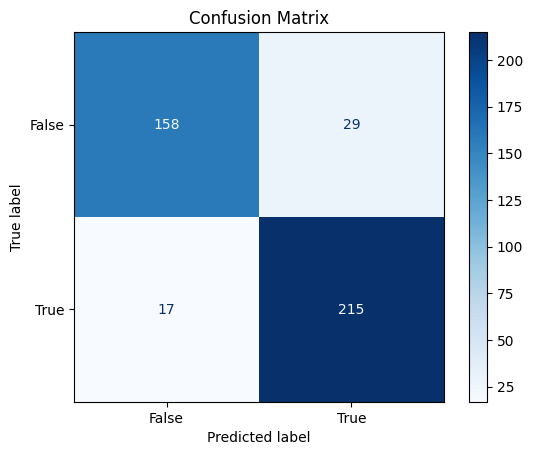


Sample Predictions:

Sample 1
Text: 189 new cases of covid19nigeria lagos70 plateau37 fct24 kaduna19 rivers12 oyo5 ogun4 ebonyi3 katsina3 ondo3 osun3 imo2 yobe2 ekiti1 nasarawa1 57145 confirmed 48431 discharged 1095 deaths httpstcoyorxfuygac
Predicted: True, Actual: True

Sample 2
Text: a photo of fatigued medical professional in the battled against covid19
Predicted: False, Actual: False

Sample 3
Text: maduros administration has authorized the use of chloroquine a medication to treat malaria that can cause heart problems if not used properly565 and interferon alfa2b565 an antiviral used on a small scale in china that has been promoted by cubas government labeled sometimes even as a vaccine
Predicted: False, Actual: False

Sample 4
Text: data on current hospitalizations remains iffy today we saw hospitalization numbers in id and nj drop by 50 which seems unlikely to reflect reality some states with rising cases have dropping hosp figures last weeks post is likely still relevant https

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print(f"\nModel Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['False', 'True']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['False', 'True'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Display a few predictions
print("\nSample Predictions:")
for i, (text, pred, true_label) in enumerate(zip(test_texts[:5], y_pred[:5], test_labels[:5])):
    print(f"\nSample {i+1}")
    print(f"Text: {text}")
    print(f"Predicted: {'True' if pred else 'False'}, Actual: {'True' if true_label else 'False'}")